In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/track.csv', dtype={'id': 'int32'})
df.shape[0], df.columns

(11021,
 Index(['id', 'start_date', 'avg_speed', 'end_date', 'length', 'max_speed',
        'norm_fuel_consumed', 'type', 'end_address', 'start_address', 'points',
        'tracker_id'],
       dtype='object'))

## Exploratory Data Analysis

Let's explore the data and look at the main descriptive statistics.

In [3]:
# type takes only one value
df.type.value_counts()

type
regular    11021
Name: count, dtype: int64

In [4]:
# check which columns contain null values if any
df.isnull().any()

id                    False
start_date            False
avg_speed             False
end_date              False
length                False
max_speed             False
norm_fuel_consumed     True
type                  False
end_address           False
start_address         False
points                False
tracker_id            False
dtype: bool

In [5]:
# find the ratio of missing data on fuel consumption
df[df.norm_fuel_consumed.isna()].shape[0] / df.shape[0]

0.8560021776608293

There are only two trackers that have information on fuel consumed. Since the data is so limited, there’s no use in showing it on the dashboard.

In [6]:
df[df.norm_fuel_consumed.notna()].tracker_id.value_counts()

tracker_id
877766    1100
877767     487
Name: count, dtype: int64

In [7]:
# are there any missing dates in the dataset
(pd.date_range(start="2024-06-24", end="2024-07-23").difference(pd.to_datetime(df.start_date).dt.date), 
pd.date_range(start="2024-06-24", end="2024-07-23").difference(pd.to_datetime(df.end_date).dt.date))

(DatetimeIndex(['2024-07-10', '2024-07-11'], dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2024-07-10', '2024-07-11'], dtype='datetime64[ns]', freq='D'))

In [8]:
# we can determine the exact period between the last track on 2024-07-09 and the first on 2024-07-12
(df[df.end_date.str.contains('2024-07-09')].end_date.max(),
df[df.start_date.str.contains('2024-07-12')].start_date.min())

('2024-07-09 04:06:57', '2024-07-12 07:02:44')

In [9]:
(pd.to_datetime(df[df.start_date.str.contains('2024-07-12')].start_date.min()) - 
 pd.to_datetime(df[df.end_date.str.contains('2024-07-09')].end_date.max()))

Timedelta('3 days 02:55:47')

We can think of several reasons for this: the data was corrupted and deleted, the data was not recorded appropriately, or there were more than two full days off for all drivers in the company (highly unlikely). We should explicitly add information on no tracks completed during this period to the aggregated data.

In [10]:
df[['avg_speed', 'length', 'max_speed']].describe()

,avg_speed,length,max_speed
count,11021.000000,11021.000000,11021.000000
mean,42.693676,15.841061,57.607930
std,8.917772,44.950464,10.689025
min,4.000000,0.330000,5.000000
25%,42.000000,4.520000,58.000000
50%,44.000000,8.170000,59.000000
75%,45.000000,13.290000,59.000000
max,109.000000,601.890000,138.000000


In [11]:
# calculate duration and more accurate average speed for each track 
df['duration'] = (pd.to_datetime(df.end_date) - pd.to_datetime(df.start_date)).dt.total_seconds() / 3600
df['avg_speed_calculated'] = df.length / df['duration']

We can visualize the distributions of average speed, length, and duration to spot anomalies in the data.

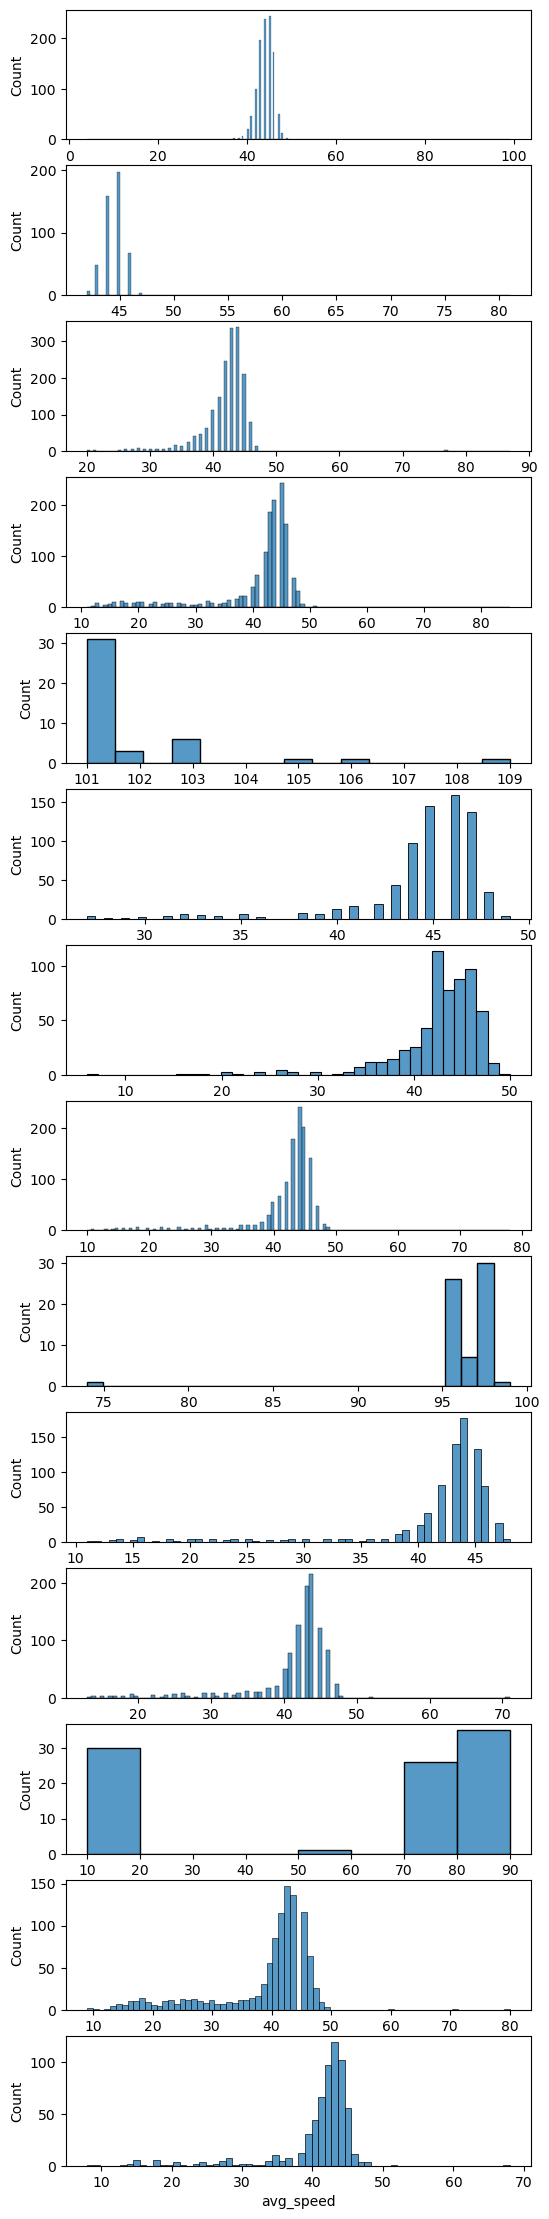

In [12]:
# distribution of average speed for each tracker individually
tracker_list = df.tracker_id.unique()
fig, axes = plt.subplots(14, 1, figsize=(6, 28))

for tracker, i in zip(tracker_list, range(14)):
    ax = sns.histplot(data=df, x=df[df.tracker_id == tracker].avg_speed, ax=axes[i])

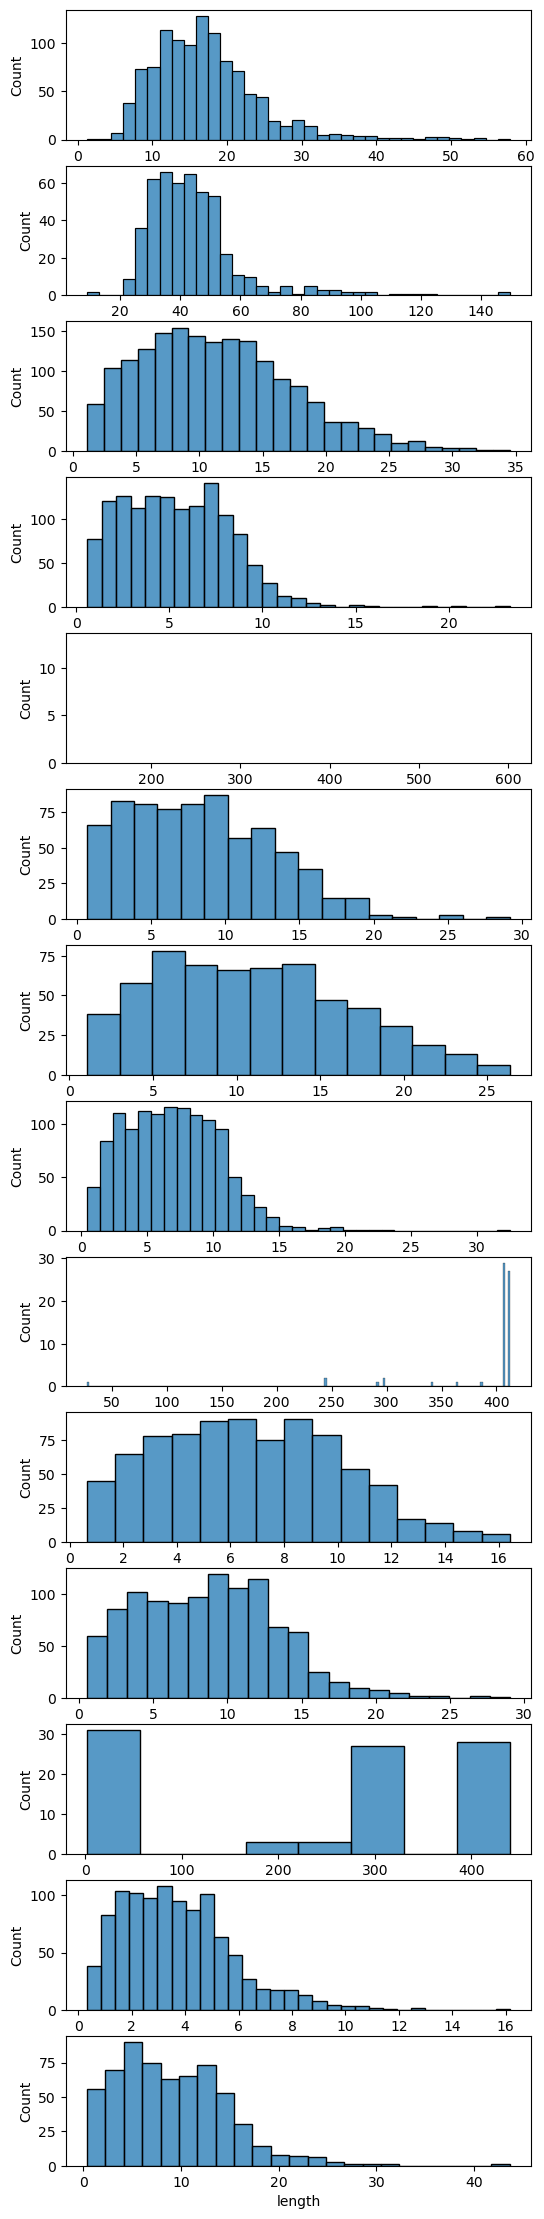

In [13]:
# distribution of track length for each tracker individually
fig, axes = plt.subplots(14, 1, figsize=(6, 28))
for tracker, i in zip(tracker_list, range(14)):
    sns.histplot(data=df, x=df[df.tracker_id == tracker].length, ax=axes[i])

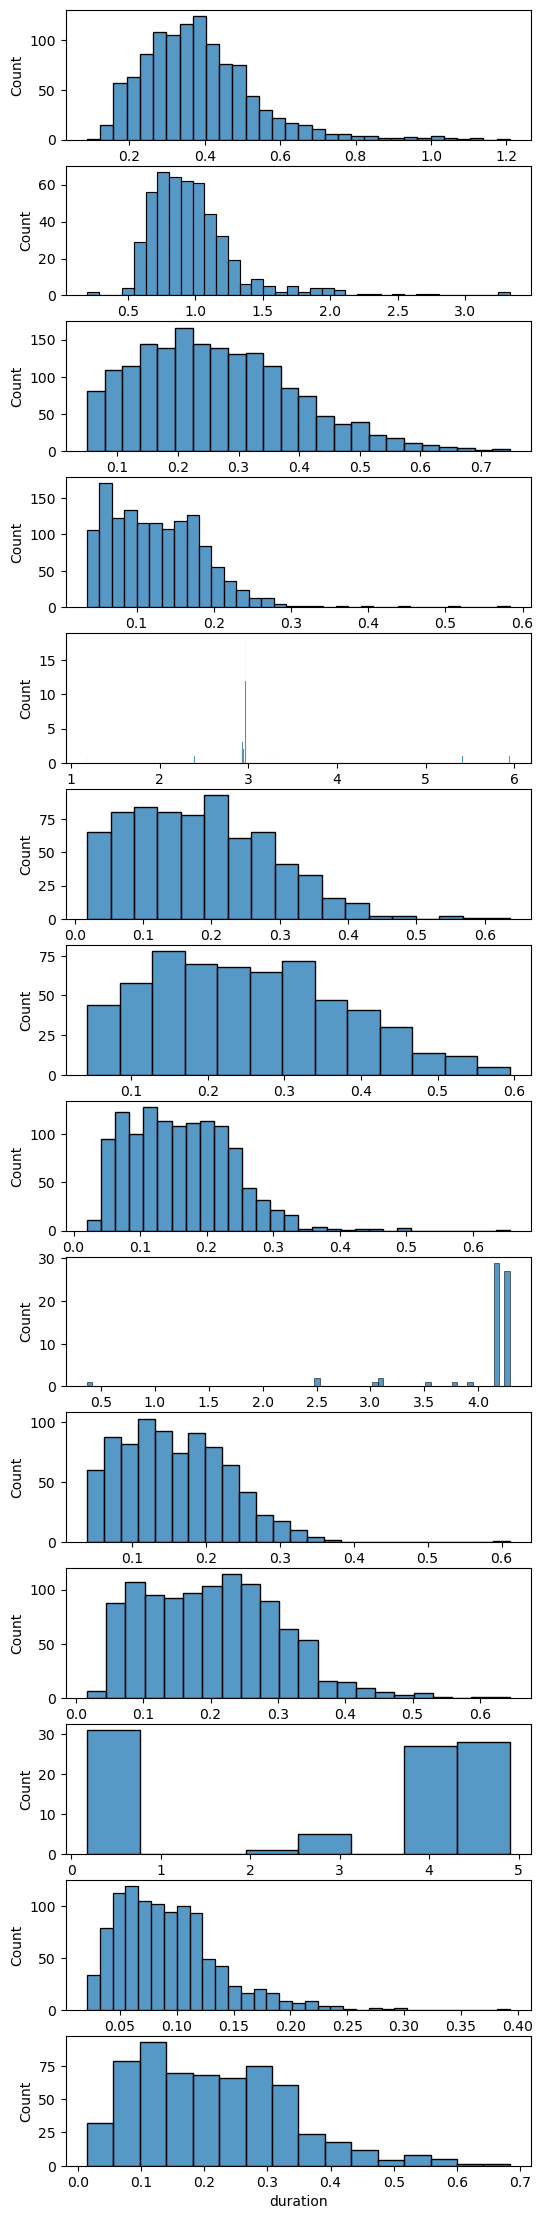

In [14]:
# distribution of track duration for each tracker individually
fig, axes = plt.subplots(14, 1, figsize=(6, 28))
for tracker, i in zip(tracker_list, range(14)):
    sns.histplot(data=df, x=df[df.tracker_id == tracker].duration, ax=axes[i])

In [15]:
# the 4th, 8th, and 11th trackers are unusual in terms of average speed, distance traveled, 
# and duration; in each case, their distributions significantly deviate from normal
tracker_list[4], tracker_list[8], tracker_list[11]

(3036045, 3036057, 3036069)

In [16]:
# look at the first 3 rows of one of the trackers
df[df.tracker_id == 3036045].head(3)

,id,start_date,avg_speed,end_date,length,max_speed,norm_fuel_consumed,type,end_address,start_address,points,tracker_id,duration,avg_speed_calculated
4708,208,2024-06-24 10:36:13,101.0,2024-06-24 13:34:42,301.00,130.0,NaN,regular,"Texas DPS - Building E, 6100, Guadalupe Street...","Texas DPS - Building E, 6100, Guadalupe Street...",2032.0,3036045,2.974722,101.185918
4709,209,2024-06-25 01:34:42,101.0,2024-06-25 04:33:14,301.06,130.0,NaN,regular,"Texas DPS - Building E, 6100, Guadalupe Street...","Texas DPS - Building E, 6100, Guadalupe Street...",2012.0,3036045,2.975556,101.177745
4710,210,2024-06-25 04:54:29,102.0,2024-06-25 07:51:13,300.89,134.0,NaN,regular,"Texas DPS - Building E, 6100, Guadalupe Street...","Texas DPS - Building E, 6100, Guadalupe Street...",2001.0,3036045,2.945556,102.150509


In [17]:
with pd.option_context("display.max_rows", 1200, "display.max_columns", 1000, 'display.max_colwidth', 1000):
    display(df.loc[df.tracker_id == 3036045, ['start_address', 'end_address']].head(1))

,start_address,end_address
4708,"Texas DPS - Building E, 6100, Guadalupe Street, Austin, Texas, United States, 78752","Texas DPS - Building E, 6100, Guadalupe Street, Austin, Texas, United States, 78752"


In [18]:
# the proportion of tracks where the starting and ending addresses coincide
(df[(df.tracker_id == 3036045) & (df.start_address == df.end_address)].shape[0] / df[(df.tracker_id == 3036045)].shape[0],
df[(df.tracker_id == 3036057) & (df.start_address == df.end_address)].shape[0] / df[(df.tracker_id == 3036045)].shape[0],
df[(df.tracker_id == 3036069) & (df.start_address == df.end_address)].shape[0] / df[(df.tracker_id == 3036045)].shape[0])

(0.7906976744186046, 0.0, 0.6976744186046512)

In [19]:
# the same happens with other trackers, but to a much lesser extent
df[(df.start_address == df.end_address)].tracker_id.value_counts()

tracker_id
3036045    34
3036069    30
3036043     4
877768      2
3036070     2
3036071     2
3036056     1
Name: count, dtype: int64

In [20]:
# let's see how many tracks are available for this 3 trackers and compare the numbers with other trackers
df[df.tracker_id.isin([3036045, 3036057, 3036069])].tracker_id.value_counts()

tracker_id
3036069    92
3036057    65
3036045    43
Name: count, dtype: int64

In [21]:
df[~df.tracker_id.isin([3036045, 3036057, 3036069])].tracker_id.value_counts()

tracker_id
877768     1770
3036043    1351
3036056    1225
877766     1100
3036068    1073
3036070    1044
3036060     834
3036047     716
3036071     617
3036049     604
877767      487
Name: count, dtype: int64

In [22]:

# calculate the averages for each tracker individually
grouped = df.groupby('tracker_id', as_index=False).agg(length_mean=('length', 'mean'),
                                                       duration_mean=('duration', 'mean'),
                                                       length_sum=('length', 'sum'),
                                                       duration_sum=('duration', 'sum'),
                                                       count=('id', 'count'))
grouped['avg_speed'] = grouped['length_sum'] / grouped['duration_sum']
grouped[['tracker_id', 'length_mean', 'duration_mean', 'avg_speed', 'count']]


,tracker_id,length_mean,duration_mean,avg_speed,count
0,877766,17.259245,0.387908,44.493132,1100
1,877767,44.392402,0.989344,44.870540,487
2,877768,11.443718,0.265586,43.088506,1770
3,3036043,5.376107,0.126264,42.578134,1351
4,3036045,309.993023,3.042590,101.884572,43
5,3036047,8.404427,0.185500,45.306772,716
6,3036049,11.052699,0.253362,43.624164,604
7,3036056,6.948539,0.161459,43.036005,1225
8,3036057,391.472923,4.039962,96.900161,65
9,3036060,6.756547,0.158535,42.618777,834


We see that trackers 3036045, 3036057, and 3036069 differ significantly from other trackers in terms of average length, duration, speed and number of tracks. Let's continue exploring the data after it has been aggregated by date.

In [23]:
# check if track ids are unique and are not reused for different trackers
df.loc[df.duplicated(subset='id', keep=False), ['id', 'tracker_id']].sort_values(by='id').head(6)

,id,tracker_id
4751,3468,3036047
5905,3468,3036049
5906,3469,3036049
4752,3469,3036047
4753,3470,3036047
5907,3470,3036049


In [24]:
# check if track ids are repeated for the same tracker
df.loc[df.duplicated(subset=['id', 'tracker_id'], keep=False), ['id', 'tracker_id']].sort_values(by='id')

,id,tracker_id


Track ids are still usable with limitations since they are not duplicated for the same tracker.

## Data Aggregation, Cleaning, and Missing Value Management

We want to get statistics on the number of finished tracks for each day, distance traveled, duration (active and off-track time), and average speed for trackers separately for each day.

In [25]:
# no tracks with duration > 24 hours
df['duration'].max()

5.948888888888889

In [26]:
# check if there are mistakes in the start/end dates
df[df.end_date <= df.start_date]

,id,start_date,avg_speed,end_date,length,max_speed,norm_fuel_consumed,type,end_address,start_address,points,tracker_id,duration,avg_speed_calculated


In [27]:
# create a column with the dates when tracks were finished
df['track_finished_date'] = pd.to_datetime(df['end_date']).dt.date

In [28]:
# select tracks that start on one day and end on another
# we need to split each of them in 2 parts (one for each day)
start = df[pd.to_datetime(df.start_date).dt.day != pd.to_datetime(df.end_date).dt.day].copy()
end = df[pd.to_datetime(df.start_date).dt.day != pd.to_datetime(df.end_date).dt.day].copy()
start['end_date'] = start['start_date'].apply(lambda x: x[:11] + '23:59:59')
end['start_date'] = end['end_date'].apply(lambda x: x[:11] + '00:00:00')

In [29]:

start['duration'] = (pd.to_datetime(start.end_date) - pd.to_datetime(start.start_date)).dt.total_seconds() / 3600
end['duration'] = (pd.to_datetime(end.end_date) - pd.to_datetime(end.start_date)).dt.total_seconds() / 3600

# using the duration data and accurately calculated average speed, 
# we can determine the distance traveled for tracks that span two days, broken down by each day
start['length_split'] = round(start['duration'] * start['avg_speed_calculated'], 2)
end['length_split'] = round(end['duration'] * end['avg_speed_calculated'], 2)

# we should note that there is some degree of inaccuracy in these calculations
# because we assume that vehicle moved with the same average speed during the whole track
# same with fuel 
start['norm_fuel_consumed'] = round(start['norm_fuel_consumed'] * start['length_split'] / start['length'], 2)
end['norm_fuel_consumed'] = round(end['norm_fuel_consumed'] * end['length_split'] / end['length'], 2)

# we don't need original (full) track length any more
start = start.drop(columns={'length'}).rename(columns={'length_split' : 'length'})
end = end.drop(columns={'length'}).rename(columns={'length_split' : 'length'})

In [30]:
# create a stats dataframe with aggregated data on the number of completed tracks for each tracker per day
stats = (df.groupby(['track_finished_date', 'tracker_id'])
         .agg({'id': 'count'})
         .reset_index()
         .rename(columns={'id':'count_finished', 'track_finished_date': 'date'}))

In [31]:
df.columns

Index(['id', 'start_date', 'avg_speed', 'end_date', 'length', 'max_speed',
       'norm_fuel_consumed', 'type', 'end_address', 'start_address', 'points',
       'tracker_id', 'duration', 'avg_speed_calculated',
       'track_finished_date'],
      dtype='object')

In [32]:
start = start[['id', 'start_date', 'avg_speed', 'end_date', 'length', 'max_speed',
        'norm_fuel_consumed', 'type', 'end_address', 'start_address', 'points',
        'tracker_id', 'duration', 'avg_speed_calculated',
        'track_finished_date']]
end = end[['id', 'start_date', 'avg_speed', 'end_date', 'length', 'max_speed',
        'norm_fuel_consumed', 'type', 'end_address', 'start_address', 'points',
        'tracker_id', 'duration', 'avg_speed_calculated',
        'track_finished_date']]

In [33]:
# replace the entries of tracks that span two days with two separate entries: one for the start day and another for the end day
df = pd.concat([df[pd.to_datetime(df.start_date).dt.day == pd.to_datetime(df.end_date).dt.day],
                start, 
                end]
              ).reset_index(drop=True)


In [34]:
# add aggregated length, duration, off-track time and average speed
df['track_active_date'] = pd.to_datetime(df['start_date']).dt.date
stats = stats.merge(df.groupby(['track_active_date', 'tracker_id'])
                    .agg({'length': 'sum'})
                    .reset_index()
                    .rename(columns={'track_active_date':'date'}), 
                            on=['date', 'tracker_id'], 
                            how='outer')
stats = stats.merge(df.groupby(['track_active_date', 'tracker_id'])
                    .agg({'duration': 'sum'})
                    .reset_index()
                    .rename(columns={'track_active_date':'date'}), 
                            on=['date', 'tracker_id'], 
                            how='outer')
stats['offtrack_time'] = 24 - stats['duration']
stats['avg_speed'] = stats['length'] / stats['duration']

In [35]:
stats

,date,tracker_id,count_finished,length,duration,offtrack_time,avg_speed
0,2024-06-24,877766,47,739.75,16.796389,7.203611,44.042205
1,2024-06-24,877767,20,856.61,19.289444,4.710556,44.408226
2,2024-06-24,877768,68,829.97,19.137222,4.862778,43.369408
3,2024-06-24,3036043,53,306.53,7.116389,16.883611,43.073812
4,2024-06-24,3036045,1,301.00,2.974722,21.025278,101.185918
...,...,...,...,...,...,...,...
367,2024-07-23,3036043,14,73.94,1.783056,22.216944,41.468141
368,2024-07-23,3036056,13,92.33,2.113611,21.886389,43.683533
369,2024-07-23,3036057,1,64.96,0.665556,23.334444,97.602671
370,2024-07-23,3036068,13,92.23,2.125556,21.874444,43.391009


Let's compare the aggregated distances and mileage, obtained from mileage endpoint

In [36]:
dfm = pd.read_csv('../data/mileage.csv')
dfm = (dfm.sort_values(by='date').reset_index(drop=True).astype({'date':'str'})
        .merge(stats[['date', 'tracker_id', 'length', 'count_finished']].sort_values(by='date').reset_index(drop=True).astype({'date':'str'}), 
                on=['tracker_id', 'date'], how='outer'))
dfm['length_diff'] = abs(dfm.mileage - dfm.length)

In [37]:
# look at examples of discrepancies for the trackers, that do not belong to the list of anomalous ones
dfm.loc[(dfm['length_diff'] > 2) & (~dfm.tracker_id.isin([3036045, 3036057, 3036069]))].sort_values(by='length_diff', ascending=False).head(10)

,tracker_id,date,mileage,length,count_finished,length_diff
8,877766,2024-07-02,792.79,750.39,44.0,42.40
52,877767,2024-07-16,661.62,627.33,14.0,34.29
188,3036047,2024-07-02,269.11,239.73,28.0,29.38
181,3036047,2024-06-25,276.66,247.65,27.0,29.01
458,3036071,2024-07-02,247.93,221.82,22.0,26.11
198,3036047,2024-07-12,264.64,238.69,28.0,25.95
22,877766,2024-07-16,625.55,600.93,27.0,24.62
428,3036070,2024-07-02,177.35,152.96,44.0,24.39
421,3036070,2024-06-25,161.42,139.66,44.0,21.76
202,3036047,2024-07-16,264.37,242.78,28.0,21.59


There are occurrences of discrepancies between the aggregated daily distance traveled and the daily mileage for each tracker

In [38]:
dfm[dfm['length_diff'] > 2].tracker_id.nunique()

14

When examining the tracks for a day with discrepancies between mileage and the sum of track lengths, we see that the end address of one track and the start address of the next track don't always coincide. Some vehicle travels might occur but are not recorded as tracks. (see rows 1442:1443)

In [39]:
with pd.option_context("display.max_rows", 1200, "display.max_columns", 1000, 'display.max_colwidth', 1000):
    display(df.loc[df.start_date.str.contains('2024-07-16') & (df.tracker_id == 877767), 
            ['id', 'start_date', 'end_date', 'length', 'start_address', 'end_address']])

,id,start_date,end_date,length,start_address,end_address
1439,19805,2024-07-16 00:01:21,2024-07-16 00:45:16,30.61,"Martin Luther King Jr., Martin Luther King Jr. Tribute Plaza, Buffalo, New York, United States, 14211","Wyldewood Beach, Port Colborne, Golden Horseshoe, Ontario, Canada, L0S 1R0"
1440,19806,2024-07-16 00:59:23,2024-07-16 02:06:44,49.26,"Wyldewood Beach, Port Colborne, Golden Horseshoe, Ontario, Canada, L0S 1R0","524, Northrup Road, Town of Elma, New York, United States, 14059"
1441,19807,2024-07-16 02:20:51,2024-07-16 03:07:27,34.39,"524, Northrup Road, Town of Elma, New York, United States, 14059","Camp Seven Hills, Dutchtown Road, Town of Sardinia, Erie County, New York, United States, 14030"
1442,19808,2024-07-16 03:21:39,2024-07-16 04:19:40,44.73,"Camp Seven Hills, Dutchtown Road, Town of Sardinia, Erie County, New York, United States, 14030","Olympiad Drive, Village of Hamburg, New York, United States, 14075"
1443,19809,2024-07-16 11:10:41,2024-07-16 12:07:50,42.42,"10695, State Highway 240, West Valley, Town of Ashford, New York, United States, 14171","7380, Jewett Holmwood Road, Town of Orchard Park, Erie County, New York, United States, 14127"
1444,19810,2024-07-16 12:21:56,2024-07-16 13:29:51,50.18,"7380, Jewett Holmwood Road, Town of Orchard Park, Erie County, New York, United States, 14127","10904, Alexander Darien Townline Road, Town of Alexander, New York, United States, 14040"
1445,19811,2024-07-16 13:43:58,2024-07-16 14:22:12,28.52,"10904, Alexander Darien Townline Road, Town of Alexander, New York, United States, 14040","4170, East Blood Road, Wales Center, Town of Wales, Erie County, New York, United States, 14037"
1446,19812,2024-07-16 14:36:18,2024-07-16 15:41:28,49.43,"4170, East Blood Road, Wales Center, Town of Wales, Erie County, New York, United States, 14037","445, Voorhees Avenue, Buffalo, New York, United States, 14216"
1447,19813,2024-07-16 15:55:35,2024-07-16 16:53:15,42.55,"445, Voorhees Avenue, Buffalo, New York, United States, 14216","2960, Randall Road, Ransomville, Niagara County, New York, United States, 14131"
1448,19814,2024-07-16 17:07:21,2024-07-16 18:05:50,45.77,"2960, Randall Road, Ransomville, Niagara County, New York, United States, 14131","Bartel Road, Town of Alabama, Town of Royalton, Niagara County, New York, United States"


In [40]:
# calculate the averages for each tracker individually when the data is aggregated by date
grouped = stats.groupby('tracker_id', as_index=False).agg(length_mean=('length', 'mean'),
                                                       duration_mean=('duration', 'mean'),
                                                       length_sum=('length', 'sum'),
                                                       duration_sum=('duration', 'sum'))
grouped['avg_speed'] = grouped['length_sum'] / grouped['duration_sum']
grouped[['tracker_id', 'length_mean', 'duration_mean', 'avg_speed']]

,tracker_id,length_mean,duration_mean,avg_speed
0,877766,678.033929,15.239077,44.493109
1,877767,772.103571,17.207351,44.870565
2,877768,723.395357,16.788611,43.088458
3,3036043,259.392143,6.092143,42.578145
4,3036045,493.688519,4.845566,101.884596
5,3036047,240.702800,5.312733,45.306772
6,3036049,267.033200,6.121222,43.624164
7,3036056,303.992143,7.063671,43.036002
8,3036057,978.673077,10.099808,96.900169
9,3036060,225.398400,5.288711,42.618777


Apart from the previously identified abnormal trackers (3036045, 3036057, and 3036069), there are three other trackers that stand out due to their mean daily duration and length (877766, 877767, 877768). This is likely because the same vehicle (and tracker) is used by two different drivers each day.

Since the dashboard will allow for aggregating data by specific groups of trackers and will also provide overall metrics, it makes sense to remove clearly abnormal data from trackers 3036045, 3036057, and 3036069.

In [41]:
stats = stats[~stats.tracker_id.isin([3036045, 3036057, 3036069])]

We should include data for the dates 2024-07-10 and 2024-07-11 so that it can be visualized properly.

In [42]:
stats.columns

Index(['date', 'tracker_id', 'count_finished', 'length', 'duration',
       'offtrack_time', 'avg_speed'],
      dtype='object')

In [43]:
df_add = pd.DataFrame(stats.tracker_id.unique().tolist(), columns=['tracker_id'])
df_add['date'] = '2024-07-10'
df_add['count_finished'] = 0
df_add['length'] = 0
df_add['duration'] = 0
df_add['offtrack_time'] = 24
df_add['avg_speed'] = 0

In [44]:
df_add = df_add[['date', 'tracker_id', 'count_finished', 'length', 
                  'duration', 'offtrack_time', 'avg_speed']]
df_add1 = df_add.copy()
df_add1['date'] = '2024-07-11'
stats = pd.concat([stats, df_add, df_add1]).reset_index(drop=True)

We should also check if any of trackers still lack data from specific dates.

In [45]:
to_add_data = {}
for tracker_id in stats.tracker_id.unique().tolist():
    missing_dates = pd.date_range(start="2024-06-24", end="2024-07-23").difference(pd.to_datetime(stats.loc[stats.tracker_id == tracker_id, 'date']).dt.date)
    if len(missing_dates) > 0:
        to_add_data[tracker_id] = missing_dates

In [46]:
to_add_data

{3036047: DatetimeIndex(['2024-07-09', '2024-07-17', '2024-07-23'], dtype='datetime64[ns]', freq=None),
 3036049: DatetimeIndex(['2024-07-09', '2024-07-17', '2024-07-23'], dtype='datetime64[ns]', freq=None),
 3036060: DatetimeIndex(['2024-07-09', '2024-07-17', '2024-07-23'], dtype='datetime64[ns]', freq=None),
 3036070: DatetimeIndex(['2024-07-09', '2024-07-17', '2024-07-23'], dtype='datetime64[ns]', freq=None),
 3036071: DatetimeIndex(['2024-07-09', '2024-07-17', '2024-07-23'], dtype='datetime64[ns]', freq=None)}

In [47]:
df_add = df_add[df_add.tracker_id.isin(to_add_data.keys())].copy()
df_add['date'] = '2024-07-09'
df_add1 = df_add.copy()
df_add1['date'] = '2024-07-17'
df_add2 = df_add.copy()
df_add2['date'] = '2024-07-23'
stats = pd.concat([stats, df_add, df_add1, df_add2]).reset_index(drop=True)

In [48]:
stats.to_csv('../data/stats.csv', index=False)